# Predicting Airbnb Price with Linear Models

**Group 15** <br>
Mathew <br>
Marcus <br>
Zahra <br>
Alizah <br>

## Introduction
1. Relevant background information on Airbnb; lay out the basic knowledge needed to understand the rest of the project (can do this later?)
2. Question
3. Describe dataset used to address question
4. Align question with existing literature (2 scientific publicatons, listed below). You can format links [like this](https://docs.google.com/document/d/1dLtaAEjd5Tk2_6ZmR5hZoDo08JzhrnGkun8D0c2D3W0/edit?tab=t.87371pud50w6#heading=h.g5nne0jxfmlg)

(copied pasted zahra's part from the doc)

Nowadays, the role of the sharing economy in tourism is increasing, and the number of people involved as guests or hosts is rising day by day. This dynamic generates a viable alternative to the traditional services, allowing tourists to customize their trips and enrich their experiences.

Airbnb began as a way for travellers to find unique, local experiences and accommodations, and for hosts to earn extra income by renting out spare rooms, apartments, or entire homes. Over time, it has expanded to include a wide range of options—from urban apartments and rural cabins to luxury villas and even treehouses—offering travellers diverse ways to stay and explore around the world.
Airbnb operates on a sharing economy model, where hosts can monetize their property by listing it on the platform. The platform is accessible via the Airbnb website or mobile app, enabling both hosts and guests to manage bookings, communicate, and leave reviews.

**About the Dataset** <br>
To conduct an analysis on predictors of Airbnb prices, we sourced the following dataset: "Airbnb Prices in European Cities" [https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities/data]. 
This dataset contains detailed Airbnb listing information from several major European cities (London, Rome, Budapest), capturing over 23,042 observations. It includes attributes such as room type, host status, guest satisfaction, number of bedrooms, and geographic data (distance from city center, latitude, and longitude), enabling spatial econometric analysis of weekday and weekend pricing. The data appears to be aggregated from Airbnb listings and reviews, reflecting both social and geographical influences on rental pricing strategies.
We want to know what the key determinants of the price of an Airbnb listing are, as this is a question of importance from both perspectives: listing a place as a host, or from the point of view of a guest looking for an accommodation. An accurate assessment of Airbnb price determinants is essential not only for tourism management but also for urban planning. Previous studies on Airbnb listings have shown that size, quality, and host reputation play a significant role, along with the location of the Airbnb.

### **Our Question:** Which factors are most useful for predicting Airbnb price?

Until now, different studies have been focussed on price determinants of Airbnb listings, their results emphasising the complexity of the relationship between pricing and its determinants. Moreover, different authors suggest that the relationship between price and its determinants differ undoubtedly across cities/countries/regions due to the variation in city types, city economics, and Airbnb development in the region.

** ADD IN LINK TO LITERATURE WITH IN TEXT CITATIONS **

## Methods and Results

### Exploratory Data Analysis
To begin our analysis, we start by reading our data, with modfications to keep it tidy.

In [1]:
# Libraries & Packages
library(tidyverse)
library(mltools)
library(rsample)
library(glmnet)

library(leaps) #regsubsets

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8



In [2]:
# Main developer: Alizah
# Contributor: Marcus (modified read function)

# Function to format & read data: 
# select vars from dataset and add city name + if it's weekend data
tidy_data <- function(path, cityName, isWeekend) {
    data <- read_csv(path, show_col_types = FALSE) %>%
        select(-...1, -attr_index, -attr_index_norm, -rest_index, -rest_index_norm)
    data$room_type <- as.factor(data$room_type)
    data$city <- as.factor(cityName)
    data$isWeekend <- as.logical(isWeekend)
    return(data)
}

# Import and format data with tidy_data()
london_weekdays <- (tidy_data("data/london_weekdays.csv", "London", 0))
london_weekends <- (tidy_data("data/london_weekends.csv", "London", 1))
rome_weekdays <- (tidy_data("data/rome_weekdays.csv", "Rome", 0))
rome_weekends <- (tidy_data("data/rome_weekends.csv", "Rome", 1))
budapest_weekdays <- (tidy_data("data/budapest_weekdays.csv", "Budapest", 0))
budapest_weekends <- (tidy_data("data/budapest_weekends.csv", "Budapest", 1))

# Merge all the data together
data <- rbind(london_weekdays, london_weekends, rome_weekdays, rome_weekends, budapest_weekdays, budapest_weekends)

# View the head and tail of the data
head(data, 3)
tail(data, 3)

New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,lng,lat,city,isWeekend
<dbl>,<fct>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
570.0981,Entire home/apt,FALSE,FALSE,2,FALSE,0,0,10,98,1,5.301018,1.5889904,-0.16032,51.46531,London,FALSE
297.9844,Private room,FALSE,TRUE,2,TRUE,1,0,10,99,1,2.198946,0.3792620,-0.09683,51.50343,London,FALSE
336.7906,Private room,FALSE,TRUE,2,FALSE,1,0,10,96,1,2.322958,0.4531776,-0.10554,51.52407,London,FALSE


realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,lng,lat,city,isWeekend
<dbl>,<fct>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
162.8519,Entire home/apt,FALSE,FALSE,4,FALSE,0,0,10,93,1,11.855169,7.9301629,19.09776,47.39608,Budapest,TRUE
129.2475,Entire home/apt,FALSE,FALSE,3,FALSE,0,1,10,90,1,1.669951,0.2725486,19.07000,47.48800,Budapest,TRUE
129.2475,Entire home/apt,FALSE,FALSE,3,FALSE,0,1,10,93,1,1.669965,0.2725244,19.07000,47.48800,Budapest,TRUE


Our data above appears to be in a tidy format, with minor inconsistencies to how booleans are represented. Otherwise, the variables have their correct representations. 

Let's go through an EDA checklist:

## Below is copied from Marcus_Project

- Packaging (& Wrangling as needed)
- Head and tail of data (presented in a tidy format)
- Check for NA values
- Check n's and summary statistics
- Plot visualizations for variables of interest

In [3]:
# Main developer: Marcus

# Packaging
str(data)

tibble [23,042 × 17] (S3: tbl_df/tbl/data.frame)
 $ realSum                   : num [1:23042] 570 298 337 227 256 ...
 $ room_type                 : Factor w/ 3 levels "Entire home/apt",..: 1 2 2 2 2 2 2 2 2 1 ...
 $ room_shared               : logi [1:23042] FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ room_private              : logi [1:23042] FALSE TRUE TRUE TRUE TRUE TRUE ...
 $ person_capacity           : num [1:23042] 2 2 2 2 3 2 2 2 4 3 ...
 $ host_is_superhost         : logi [1:23042] FALSE TRUE FALSE TRUE FALSE FALSE ...
 $ multi                     : num [1:23042] 0 1 1 1 0 0 0 1 1 0 ...
 $ biz                       : num [1:23042] 0 0 0 0 0 0 0 0 0 1 ...
 $ cleanliness_rating        : num [1:23042] 10 10 10 10 9 10 10 10 9 8 ...
 $ guest_satisfaction_overall: num [1:23042] 98 99 96 99 98 100 100 95 93 74 ...
 $ bedrooms                  : num [1:23042] 1 1 1 1 1 1 1 1 1 0 ...
 $ dist                      : num [1:23042] 5.3 2.2 2.32 5.71 3.26 ...
 $ metro_dist                :

In [4]:
# Main developer: Zahra

# Check for missing/NA values
anyNA(data)

[1] FALSE

In [5]:
# Main developer: Marcus

# Compute summary statistics & check numbers
dim(data)
summary(data)

[1] 23042    17

    realSum                   room_type     room_shared     room_private   
 Min.   :   34.78   Entire home/apt:13534   Mode :logical   Mode :logical  
 1st Qu.:  144.05   Private room   : 9432   FALSE:22966     FALSE:13610    
 Median :  195.92   Shared room    :   76   TRUE :76        TRUE :9432     
 Mean   :  268.47                                                          
 3rd Qu.:  296.57                                                          
 Max.   :15499.89                                                          
 person_capacity host_is_superhost     multi             biz      
 Min.   :2.000   Mode :logical     Min.   :0.0000   Min.   :0.00  
 1st Qu.:2.000   FALSE:16996       1st Qu.:0.0000   1st Qu.:0.00  
 Median :3.000   TRUE :6046        Median :0.0000   Median :0.00  
 Mean   :3.168                     Mean   :0.3234   Mean   :0.36  
 3rd Qu.:4.000                     3rd Qu.:1.0000   3rd Qu.:1.00  
 Max.   :6.000                     Max.   :1.0000   Max.   :1.00  

From the above summary statistics, we note the presence of outliers in `realSum` with a max of `15499.89`, which is much higher than the mean of `268.47`. 

A histogram of `realSum` will help visualize the distribution of our response and to remove outliers, to better understand possible relationships between `realSum` and the predictors.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


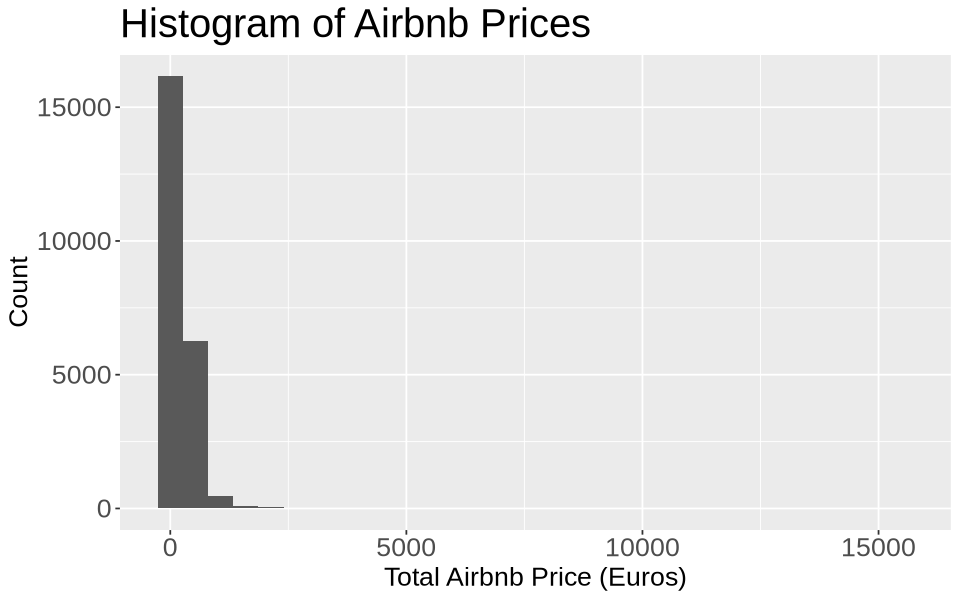

In [6]:
# Main developer: Marcus

# Plot a histogram of our response
options(repr.plot.width = 8, repr.plot.height = 5)

realSum_hist <- data %>%
    ggplot(aes(x=realSum)) +
    geom_histogram() +
    labs(title="Histogram of Airbnb Prices", x="Total Airbnb Price (Euros)", y="Count") +
    theme(axis.text = element_text(size = 16), 
          axis.title = element_text(size = 16),
         title=element_text(size = 20))

realSum_hist

Above, we clearly have large outliers in `realSum`. Let's filter the data to remove `realSum` above 1000 euros. In addition, lets plot the mean, and the 95th percentile.

It appears that our response data is very right skewed. 95% of Airbnb price listngs fall below ~`640`, with the average at around `280`. The threshold of `1000` still covers over 95% of listings, and thus is suitable.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


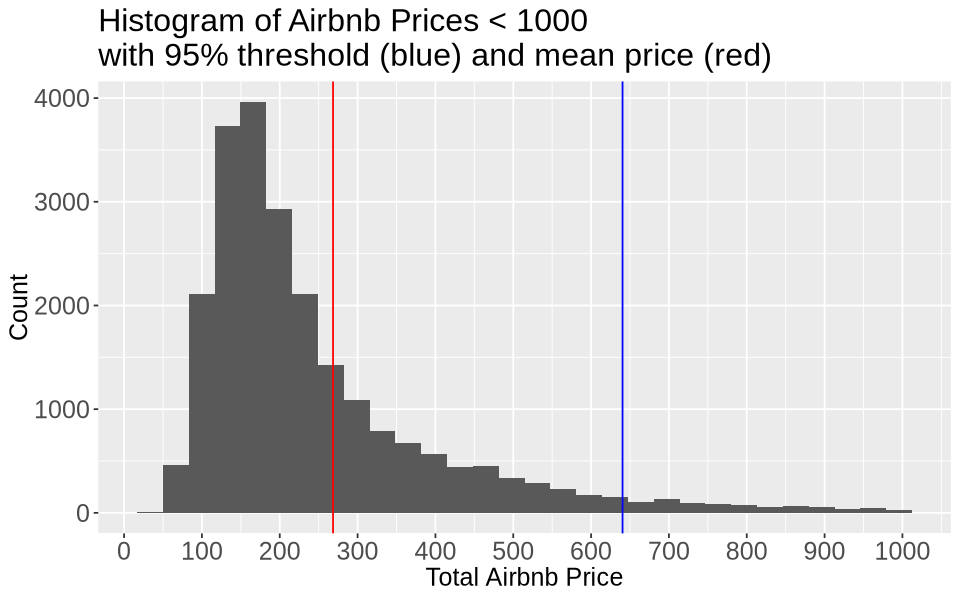

In [7]:
# Main developer: Marcus

data_filt <- data %>% 
    filter(realSum < 1000)

realSum_hist_filt <- data_filt %>%
    ggplot(aes(x=realSum)) +
    geom_histogram() +
    geom_vline(xintercept=mean(data$realSum), color = "red") +
    geom_vline(xintercept=quantile(data$realSum, 0.95), color = "blue") +
    scale_x_continuous(breaks=seq(0, 1000, 100)) +
    ggtitle("Histogram of Airbnb Prices < 1000\nwith 95% threshold (blue) and mean price (red)") +
    labs(x="Total Airbnb Price", y="Count") +
    theme(axis.text = element_text(size = 15), 
          axis.title = element_text(size = 15),
         title=element_text(size = 16))
    

realSum_hist_filt

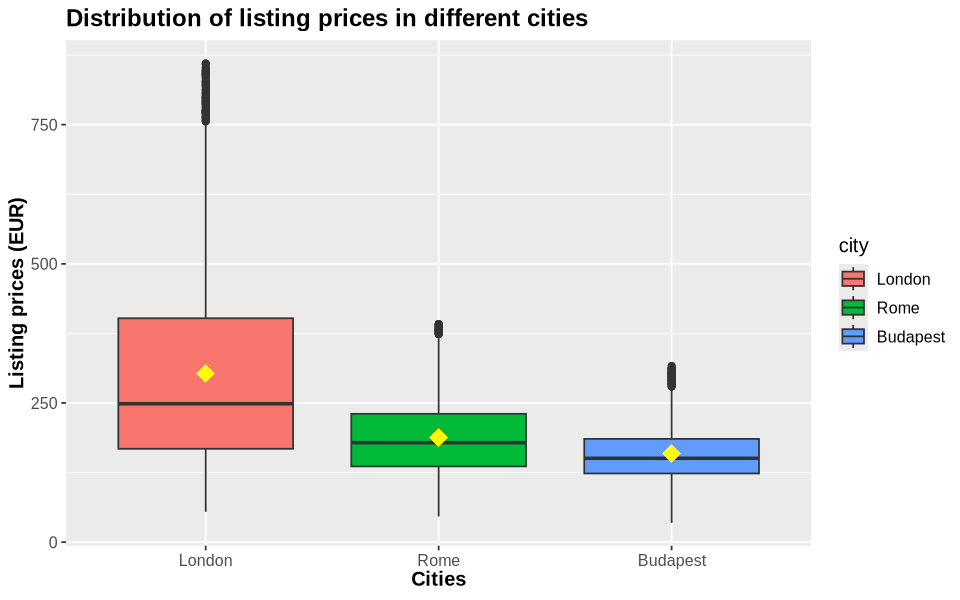

In [34]:
# Main developer: Matthew

# Filters rows with N/A from the data
data <- drop_na(data)

#Altering columns to correct object types and filtering outliers
tidy_data <-
    data %>%
    mutate(   #change columns into correct object types
            across(c(room_type,city),as.factor),
            across(c(multi,biz,isWeekend),as.logical)
    ) %>%
    group_by(city) %>%
    filter(  #filtering outliers from each city by removing listing with prices that lies at the upper 5%
        realSum <= quantile(realSum, 0.95, na.rm = TRUE)) %>%
    ungroup()

#To examine the distribution of listing prices in different cities through a boxplot
city_listing_plot <-
    tidy_data %>%
    ggplot() +
    geom_boxplot(aes(x=city,y=realSum,fill=city))+
    ggtitle("Distribution of listing prices in different cities")+
    xlab("Cities")+
    ylab("Listing prices (EUR)")+
    stat_summary(aes(x=city, y=realSum),
        fun = mean, geom = "point", colour = "yellow", 
        shape = 18, size = 5
    ) +
    theme(
        text = element_text(size = 12),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold")
    )
city_listing_plot

The box plot above that shows the distribution of listing prices across Budapest, London and Rome, it helps with the question as it allows one to see how the listing prices varies between cities.

Starting with Budapest, it has the smallest variability in its distribution as well as the lowest median and mean. London, has the largest variability in its distribution and higher median and mean. Lastly, Rome has a variability in its distribution of listing prices thats relatively larger than Budapest as well a larger median and mean than Budapest but lower than London.

Budapest and Rome shares a relatively similar distribution, median and mean of listing prices to one another, but London's wider distribution and higher median and mean may affect the goodness of fit of the model.


Next, [describe more plots here]

> Marcus: I'm not sure if other plots of the raw data are relevant, since we plan to use forward selecton

## Analysis Plan

Since we are analyzing a prediction question, it's important that we separate the data into testing and training sets to prevent double-dipping and to get an accurate understanding of the our model's scalability. The rsample package will help us for this task. We will use initial_split() to randomly split our dataset, with 70% for training use. We will use the training() and testing() functions to extract the training and testing data respectively. 

### Training: 
We will only use the training dataset here. We have 16 variables in our dataset that could be possible predictors of Airbnb listing price. We can use statistical variable selection process to determine which factors may be most useful in predicting our response. We can decide between subset selection methods (stepAIC() and regsubset()) and regularization methods (LASSO and Ridge). Regularization accounts for model complexity to better protect against overfitting, thus making it more applicable for predictive uses. Since LASSO is able to zero-out coefficients, we will use it to decide which variables are not included in the model.

In order to use LASSO effectively, we must first find the best penalty term - the one that minimizes prediction error on unseen data. We can use cross validation to find this optimal value using the glmnet package. We will create a cross-validation model that utilizes LASSO, then select the lambda with the lowest MSE. We can also extract the coefficients from this model to see which variables have been selected and their relative association to realSum.


### Testing:
We will only use the testing dataset here. With our model completed, we can move on to predictions. We will use predict() with our cross-validation LASSO model, our selected penalty term, and our testing dataset to generate predicted values for realSum. 

### Evaluate Results:
With our actual and predicted values, we can calculate the root-mean squared error using rmse() (from mltools) and examine its magnitude. A lower RMSE indicates that our model is good at predicting realSum values. We can use plot() with our predicted and actual values as a visual aid of our model's performance. We can evaluate the simplicity of our model by seeing how many variables are use as predictors compared to the total number of variables in the dataset. Finally, we will create a plot of our residuals (plot()) and a QQplot (qqnorm()) to ensure our assumptions for a linear model aren't violated. 

## Results

### Using LASSO

In [27]:
set.seed(1515)
#Split data between training and testing data
data_split <- initial_split(tidy_data, prop = 0.8, strata = realSum)
training_data <- training(data_split)
testing_data <- testing(data_split)

In [28]:
#Separating the covariates and response in the training data
inputs <- model.matrix(realSum ~ .  - 1, data = training_data)[, -1]
y_vals <- training_data$realSum

#Fitting a LASSO model to the training data
cv_lasso <- cv.glmnet(inputs, y_vals, alpha = 1)

#Extracting the best penalty term, the lambda with the lowest MSE
best_lambda <- cv_lasso$lambda.min

#Extracting coefficients of the best lasso model
beta_lasso <- coef(cv_lasso, s = "lambda.min")

summary(cv_lasso)
best_lambda
beta_lasso

           Length Class  Mode     
lambda     66     -none- numeric  
cvm        66     -none- numeric  
cvsd       66     -none- numeric  
cvup       66     -none- numeric  
cvlo       66     -none- numeric  
nzero      66     -none- numeric  
call        4     -none- call     
name        1     -none- character
glmnet.fit 12     elnet  list     
lambda.min  1     -none- numeric  
lambda.1se  1     -none- numeric  
index       2     -none- numeric  

[1] 0.1457018

19 x 1 sparse Matrix of class "dgCMatrix"
                                      s1
(Intercept)                 2.024600e+02
room_typePrivate room      -1.217622e+02
room_typeShared room       -1.291976e+02
room_sharedTRUE            -2.513109e-10
room_privateTRUE            .           
person_capacity             1.609612e+01
host_is_superhostTRUE      -1.084716e+00
multiTRUE                   1.700303e+01
bizTRUE                     2.595718e+01
cleanliness_rating          8.535026e+00
guest_satisfaction_overall -2.563524e-01
bedrooms                    3.373414e+01
dist                       -1.294123e+01
metro_dist                 -1.159035e+00
lng                        -1.319584e+01
lat                         1.708808e+00
cityRome                    .           
cityBudapest                .           
isWeekendTRUE               5.423005e+00

In [29]:
#Separating the covariates and response in the testing data
new_inputs <- model.matrix(realSum ~ .  - 1, data = testing_data)[, -1]
actuals <- testing_data$realSum

# Predicting listing prices (realSum) with cv_lasso
predictions <- predict(cv_lasso, s = "lambda.min", newx = new_inputs)

rmse <- rmse(actuals, predictions)
rmse
# plot(actuals, predictions, main = "Actual vs Predicted", xlab = "Actual", ylab = "Predicted")

[1] 89.26071

In [12]:
# residuals <- actuals - predictions
# plot(predictions, residuals,
#      main = "Residuals vs Fitted (Predicted)",
#      xlab = "Fitted values", ylab = "Residuals",
#      pch = 19, col = "steelblue")
# abline(h = 0, col = "red", lwd = 2)
# qqnorm(residuals)

### had a mental breakdown from the rmse.... using regsubsets

In [30]:
regfit_full <- regsubsets(realSum ~ ., data = training_data, nvmax = 16, method = "forward")
summary(regfit_full)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“2  linear dependencies found”


Reordering variables and trying again:


Warning message in rval$lopt[] <- rval$vorder[rval$lopt]:
“number of items to replace is not a multiple of replacement length”


Subset selection object
Call: regsubsets.formula(realSum ~ ., data = training_data, nvmax = 16, 
    method = "forward")
18 Variables  (and intercept)
                           Forced in Forced out
room_typePrivate room          FALSE      FALSE
room_typeShared room           FALSE      FALSE
person_capacity                FALSE      FALSE
host_is_superhostTRUE          FALSE      FALSE
multiTRUE                      FALSE      FALSE
bizTRUE                        FALSE      FALSE
cleanliness_rating             FALSE      FALSE
guest_satisfaction_overall     FALSE      FALSE
bedrooms                       FALSE      FALSE
dist                           FALSE      FALSE
metro_dist                     FALSE      FALSE
lng                            FALSE      FALSE
lat                            FALSE      FALSE
cityRome                       FALSE      FALSE
cityBudapest                   FALSE      FALSE
isWeekendTRUE                  FALSE      FALSE
room_sharedTRUE                FA

In [31]:
selected_vars <- summary(regfit_full)$which[which.min(summary(regfit_full)$bic), ]
selected_vars <- names(selected_vars)[selected_vars == TRUE]
selected_vars <- selected_vars[selected_vars != "(Intercept)"]  # remove intercept
selected_vars

[1] "room_typePrivate room"      "room_sharedTRUE"           
 [3] "person_capacity"            "multiTRUE"                 
 [5] "bizTRUE"                    "cleanliness_rating"        
 [7] "guest_satisfaction_overall" "bedrooms"                  
 [9] "dist"                       "metro_dist"                
[11] "lng"                        "lat"                       
[13] "cityRome"                   "cityBudapest"              
[15] "isWeekendTRUE"

In [32]:
# Fit the model
model_data <- training_data %>% select(room_type, person_capacity, multi, biz, cleanliness_rating, bedrooms, dist, metro_dist, lng, lat, city, isWeekend, realSum)
mlr_model <- lm(realSum ~ ., data = model_data)

# View summary
summary(mlr_model)


Call:
lm(formula = realSum ~ ., data = model_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-226.21  -59.58  -12.69   41.87  633.29 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -7404.6688  1493.0003  -4.960 7.13e-07 ***
room_typePrivate room  -119.1699     1.7462 -68.245  < 2e-16 ***
room_typeShared room   -125.6922    11.0212 -11.405  < 2e-16 ***
person_capacity          16.3260     0.7610  21.454  < 2e-16 ***
multiTRUE                17.8896     1.7058  10.488  < 2e-16 ***
bizTRUE                  27.9399     1.7353  16.101  < 2e-16 ***
cleanliness_rating        6.9200     0.6991   9.898  < 2e-16 ***
bedrooms                 34.2382     1.4755  23.204  < 2e-16 ***
dist                    -12.4672     0.4115 -30.299  < 2e-16 ***
metro_dist                3.0879     0.9220   3.349 0.000812 ***
lng                    -228.2003    14.9115 -15.304  < 2e-16 ***
lat                     148.5626    28.9675   5.129 2.95e-0

In [33]:
inputs_regsubsets <- testing_data %>% select(room_type, person_capacity, multi, biz, cleanliness_rating, bedrooms, dist, metro_dist, lng, lat, city, isWeekend, realSum)

predictions_regsubsets <- predict(mlr_model, inputs_regsubsets)

rmse_regsubsets <- rmse(actuals, predictions_regsubsets)
rmse_regsubsets
# plot(actuals, predictions_regsubsets, main = "Actual vs Predicted", xlab = "Actual", ylab = "Predicted")

[1] 88.44852

In [17]:
# residuals_regsubsets <- actuals - predictions_regsubsets
# plot(predictions_regsubsets, residuals_regsubsets,
#      main = "Residuals vs Fitted (Predicted)",
#      xlab = "Fitted values", ylab = "Residuals",
#      pch = 19, col = "steelblue")
# abline(h = 0, col = "red", lwd = 2)
# qqnorm(residuals_regsubsets)

## Discussion

In this section, you’ll interpret the results you obtained in the previous section with respect to the main question/goal of your project.

    Summarize what you found and the implications/impact of your findings.
    If relevant, discuss whether your results were what you expected to find.
    Discuss how your model could be improved;
    Discuss future questions/research this study could lead to.

## References

- Toader, V., Negrușa, A. L., Bode, O. R., & Rus, R. V. (2021). Analysis of price determinants in the case of Airbnb listings. Economic Research-Ekonomska Istraživanja, 35(1), 2493–2509. https://doi.org/10.1080/1331677x.2021.1962380
- Gyódi, K., & Nawaro, Ł. (2021). Determinants of airbnb prices in European cities: A spatial econometrics approach. Tourism Management, 86. https://doi.org/10.1016/j.tourman.2021.104319
- PUT IN MLA: https://www.tandfonline.com/doi/full/10.1080/1331677X.2021.1962380#abstract https://www.sciencedirect.com/science/article/pii/S0261517721000388?via%3Dihub
- ADD OUR KAGGLE LINK AS MLA!!!


# Individual Projects

## 4) Methods and Plan (MARCUS)

To answer my question, “*Is there an association between Airbnb prices to the distance to the closest metro and if the listing is for weekends?*“, I will use an additive MLR model using `lm()`, with the formula: `realSum ~ metro_dist + isWeekend`. This method is appropriate, because `lm()` allows us to quantify and test the significance of associations, with interpretable coefficients. Through hypothesis testing, we will either have evidence suggesting statistically significant associations (a p-value less than a chosen significance level for that coefficient), or not enough evidence.

However, we need to make the following assumptions:
- Linearity: There is a linear relationship between `realSum` and `metro_dist`.
- Independence: The errors (observations) are independent of each other.
- Normality: Under the CLT, since our data contains 23042 observations, the data and errors in the data are assumed to be normally distributed.
- Homoscedasticity: The errors have constant variance.
- There is no interaction between `metro_dist` and `isWeekend` on Airbnb prices. That is, the estimated change in Airbnb price for every change in distance to the metro does not differ depending on if the listing is on a weekend or not.
- The covariates are not highly correlated (multicollinearity)

There are also the following limitations:
- Incorrect Assumptions: If some of our assumptions turn out to be false, then our results may be invalid or require corrections. For instance, if the relationship is non-linear, we may need to transform some covariates.
- Confounding: Since the model only includes two variables, there may be other variables that influence both price and metro distance (ie. city). This could result in biased estimates, if not included in the model.
- Outliers: Based on the EDA, the data is skewed with outliers, which may result in a model that does not capture representative patterns.


## (4) Methods and Plan (ALIZAH)

We are planning on using multiple linear regression with interaction to estimate Airbnb prices based on city and distance from city centre. An MLR model is the appropriate choice for answering an inference question with 2 inputs and continuous numerical response. We will consider a model with interaction due to the results of the EDA: it seems the slope between `dist` and `realSum` are dependent on city. The formula for this regression will be: `realSum ~ city * dist`.<br>
As with any model, there are certain assumption made about the data. The assumptions about MLR with interactionin relation to our data is as follows: <br>

- **Linearity:** Based on our EDA, we are assuming that our response is approximately a linear function of our inputs and their interaction term  
- **Independence of Errors:** We assume that are observations are independent of each other. This data is from an outside source so we can never know this for sure.  
- **Homoscedasticity:** We can test if the variance of errors is constant through a residuals vs fitted values plot.  
- **Normality of Residuals:** We can see if the residuals have a normal distribution through a Q-Q plot.  
- **Minimal Multicollinearity:** We can check if our inputs are highly correlated through their VIF score.  
- **Correct Specification:** We are assuming that we have correctly specified the model with an interaction term from the result of our EDA. 
- **Correct Variable Encoding:** We ensured that, when we loaded the data, each relevant variable had the correct variable type for the model.  

Following these assumptions ensures that the results from our model are appropriate for inference since we can attain reliable estimates, confidence intervals, and errors.
There are still possible difficulties and weaknesses of our choice in model. Violating some of the assumptions may mean we cannot answer our question since it relies on making inferences. Adding in an interaction term could possible lead to overfitting the model, which may lead to poor predictions. Having too few input variables may mean that we result in a model with high errors if we are missing the potentially large impact of other variables. There's always the possiblity of confounding variables as well. Since this is an external observational study, we cannot easily discover or isolate them from the data. 

To summarize, we can use a MLR model with interaction to infer the association between the listing price of all Airbnbs in Rome, Budapest, and London depending on their city and distance from city centre. Our EDA justifies the appropriateness of this model. However, there are assumptions for this type of model we'd have to further test for and other possible weaknesses that may prevent us from answering our inference question.

<h3><b>4.Methods and Plan (ZAHRA) <b></h3> 

<p>
    To address the question of how <strong>Airbnb price (<code>realSum</code>)</strong> is associated with 
    <strong>distance from the city center (<code>dist</code>)</strong> and 
    <strong>business use (<code>biz</code>)</strong>, 
    I propose using a <strong>multiple linear regression model with an interaction term</strong>:
  </p>




<blockquote><code>realSum ~ biz * dist</code></blockquote>

<p>
    This model includes both the main effects and their interaction, enabling us to determine whether 
    the relationship between price and distance varies by business use status.
  </p>


<h3>Why is this method appropriate?</h3>
  <ul>
    <li>Multiple linear regression models are suitable for analyzing the effect of several predictors on a continuous outcome.</li>
    <li>There is an interaction between  <b>biz</b> and <b>dist</b> as shown by the scatterplot above </li>
    <li>The method is interpretable and statistically efficient when assumptions are met.</li>
  </ul>

<h3>Assumptions of the Method</h3>
  <ul>
    <li><strong>Linearity:</strong> A linear relationship exists between predictors and the outcome.</li>
    <li><strong>Independence:</strong> Observations are independent.</li>
    <li><strong>Homoscedasticity:</strong> Constant variance of residuals across predictor values.</li>
    <li><strong>Normality of residuals:</strong> Residuals should follow a normal distribution.</li>
    <li><strong>No multicollinearity:</strong> Predictors should not be highly correlated.</li>
  </ul>


 <h3>Potential Limitations or Weaknesses</h3>
  <ul>
    <li>Price data may be skewed or contain outliers that violate regression assumptions.</li>
    <li>The relationship may not be strictly linear, limiting model fit.</li>
    <li>Interpreting interaction terms can be complex.</li>
    <li>Unmeasured variables (e.g., amenities, neighborhood) might bias results.</li>
  </ul>

## Methods and plans (MATTHEW)

To answer the question, I believe the best method to approach it would be the Multi-Linear Regression (MLR) model. This is because the MLR model would allow me to observe and predict the change in the price of the listings with every unit increase in distance from city centre or between different room capacities in each city. Two assumptions that will be made for this model is that the change in the price of the listings with the change of room capacities is the same across all cities, and the other assumption is that the change in price of listings with every kilometer increase of distance from the city centre is different between cities. There are limitations of this method, such that if the response and inputs aren't linearly related, it may lead to a model with poor fit. It also assumes that the variation of residuals are homoschedastic, it will affect the standard error of our estimators and invalidate our confidence intervals and p-values if they are heterschedastic. 

Testing push - Alizah

Testing push - Matthew

testing push - Zahra